TLDR: Removing the bright spots solves the issue.

In [1]:
import torch
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F
from torch.utils.data import DataLoader
from surface_dice import SurfaceDiceMetric
import albumentations as A
import random
import matplotlib.cm as cm
import segmentation_models_pytorch as smp
from math import ceil
from patcher import Patcher

hostname = os.uname().nodename
input_dir = "data/blood-vessel-segmentation/" if hostname == "gamma" else "/kaggle/input/blood-vessel-segmentation"
device = "cuda" if torch.cuda.is_available() else "cpu"
train_dir = input_dir + "train/"

# reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(seed)

/home/dmorara/miniconda3/envs/kaggle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load model to make predictions

In [2]:
net = smp.Unet(
    encoder_name="timm-mobilenetv3_small_075",
    encoder_weights=None,
    in_channels=1,
    classes=1,
)
net.load_state_dict(torch.load("baseline_train_sdc_0.45801931619644165.pth"))
net.to(device)
net.eval();

In [3]:
imgs_dir = f"{train_dir}kidney_1_dense/images/"
msks_dir = f"{train_dir}kidney_1_dense/labels/"

patch_size = 224

img1_path = imgs_dir + "1028.tif"
img2_path = "1028_mod.tif"

# image with the bright spot
img1 = np.array(Image.open(img1_path), dtype=np.float32)
# image without the bright spot
img2 = np.array(Image.open(img2_path), dtype=np.float32)

x1 = torch.from_numpy(img1)[None, :]
x2 = torch.from_numpy(img2)[None, :]

x1_clipped = x1.clip(max=31000) / x1.clip(max=31000).max()
x1_const = x1 / 31000
x1 /= x1.max()
x2 /= x2.max()


## Take an image with a bridght spot

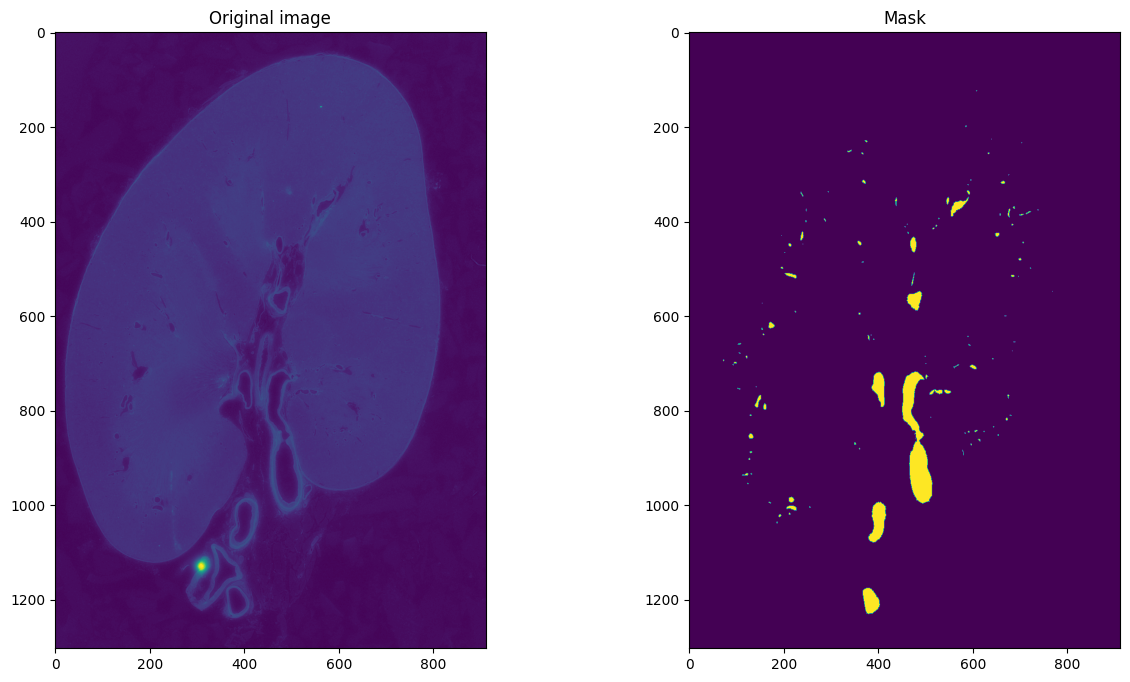

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

axs[0].set_title("Original image")
axs[1].set_title("Mask")
axs[0].imshow(cv2.imread(imgs_dir + "1028.tif", cv2.IMREAD_GRAYSCALE))
axs[1].imshow(cv2.imread(msks_dir + "1028.tif", cv2.IMREAD_GRAYSCALE))
plt.show()

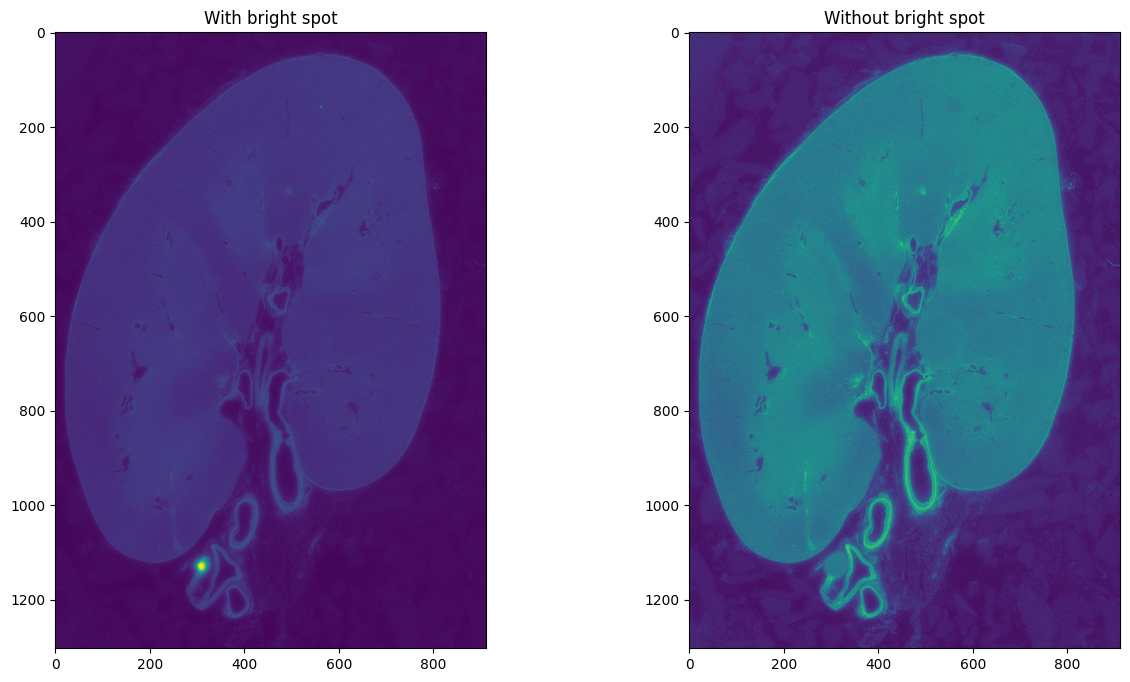

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

axs[0].set_title("With bright spot")
axs[1].set_title("Without bright spot")
axs[0].imshow(cv2.imread(imgs_dir + "1028.tif", cv2.IMREAD_GRAYSCALE))
axs[1].imshow(cv2.imread("1028_mod.tif", cv2.IMREAD_GRAYSCALE))
plt.show()

## Setup patcher

In [6]:
h, w = img1.shape[-2:]
print(h, w)

overlap = 50
patcher = Patcher(h, w, patch_size=patch_size, overlap=overlap)

x1_clipped = patcher.extract_patches(x1_clipped)  
x1_const = patcher.extract_patches(x1_const)  
x2 = patcher.extract_patches(x2)  
x1 = patcher.extract_patches(x1)  

1303 912


In [7]:
def pred(x, norm_patches=False):
    x = x.to(device)
    with torch.no_grad():
        x = x.reshape(-1, 1, patch_size, patch_size)  # (40, 1, patch_size, patch_size)
        if norm_patches:
            x /= x.max(0, keepdim=True).values
        logits = net(x) 
        logits = logits.view(1, -1, patch_size, patch_size)  
        logits = patcher.merge_patches(logits).squeeze()  # (bs, h, w)
    return logits.cpu()


In [8]:
probs1 = pred(x1).sigmoid() 
probs2 = pred(x2).sigmoid()
probs1_clipped = pred(x1_clipped).sigmoid() 
probs1_const = pred(x1_const).sigmoid() 


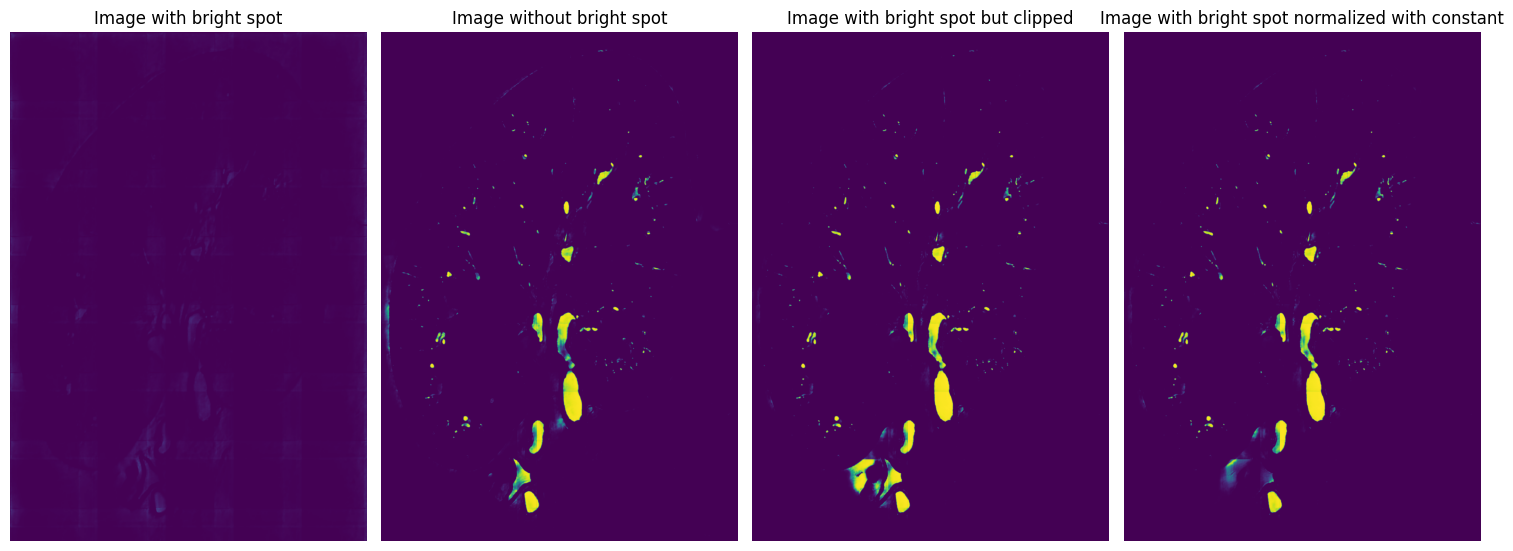

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(15, 8))

axs[0].set_title("Image with bright spot")
axs[0].imshow((cm.viridis(probs1) * 255).astype(np.uint8))

axs[1].set_title("Image without bright spot")
axs[1].imshow((cm.viridis(probs2) * 255).astype(np.uint8))

axs[2].set_title("Image with bright spot but clipped")
axs[2].imshow((cm.viridis(probs1_clipped) * 255).astype(np.uint8))

axs[3].set_title("Image with bright spot normalized with constant")
axs[3].imshow((cm.viridis(probs1_const) * 255).astype(np.uint8))

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')

plt.tight_layout()
plt.show()